In [15]:
#%% Modules
import pyvisa as visa
import awg_support as awg
import numpy as np 
import matplotlib.pyplot as plt
import csv
import time
import serial

In [18]:
#%% Initialisation
# Setup for the tools
ID_awg = 'USB0::0xF4EC::0x1102::SDG2XFBC7R0482::INSTR'
rm = awg.resourcer()
inst_awg = awg.initialise(ID_awg, rm)

ser = serial.Serial('COM3', 115200, timeout=1)

In [19]:
sd = 1.1 
Ts = 1/8e6
tw = np.arange(0, 1, Ts)

In [20]:
def run(sd):
    pset_val = 0
    pset = []
    pset_i = []
    pmeas = []
    pmeas_i = []
    bias = []
    bias_i = []
    i = 0
    while True:
        if ser.in_waiting > 0:
                try:
                    line = ser.readline()
                    val = line.decode('utf-8').strip()  # Attempt to decode as UTF-8
                    #print(val)
                    if(val == "set p ="):
                        line = ser.readline()
                        val = line.decode('utf-8').strip()  # Attempt to decode as UTF-8
                        pset_val = float(val)
                        print("p set = ", pset_val)
                        pmeas.append(pmeas_i)
                        pset.append(pset_i)
                        bias.append(bias_i)
                        pmeas_i = []
                        pset_i = []
                        bias_i = []
                    elif(val == "end"):
                        pmeas.append(pmeas_i)
                        pset.append(pset_i)
                        pmeas_i = []
                        pset_i = []
                        print("end")
                        break
                    else:
                        val = line.decode('utf-8').strip()  # Attempt to decode as UTF-8
                        pmeas_i.append(float(val))
                        pset_i.append(pset_val)
                        line = ser.readline()
                        val = line.decode('utf-8').strip()  # Attempt to decode as UTF-8
                        bias_i.append(float(val))
                        # print("p = ", pmeas_i[-1])
                except ValueError:
                    continue
                except UnicodeDecodeError:
                    print("error")
    return pset, pmeas, bias

In [21]:
awg.set_output_state(inst_awg,channel=2,val="ON")
wave = np.random.normal(0,sd,size=np.shape(tw))
awg.arb_wave_constructor(inst_awg, wave, tw,freq=80e3,channel=2)

Pset, Pmeas, Bias = run(sd)


p set =  0.93
p set =  0.87
p set =  0.64
p set =  0.27
p set =  0.34
p set =  0.69
p set =  0.56
p set =  0.7
p set =  0.02
end


In [22]:
ser.close()
awg.set_output_state(inst_awg,channel=2,val="OFF")
awg.set_output_state(inst_awg,channel=1,val="OFF")
awg.deinitialise(inst_awg)
awg.deinitialise(rm)

In [23]:
P_meas = np.array(Pmeas[1:]).flatten()
P_set = np.array(Pset[1:]).flatten()
V_bias = np.array(Bias[1:]).flatten()
f = 50 #Hz
n = 10
t = np.arange(0, len(P_set)*n/f, n/f)

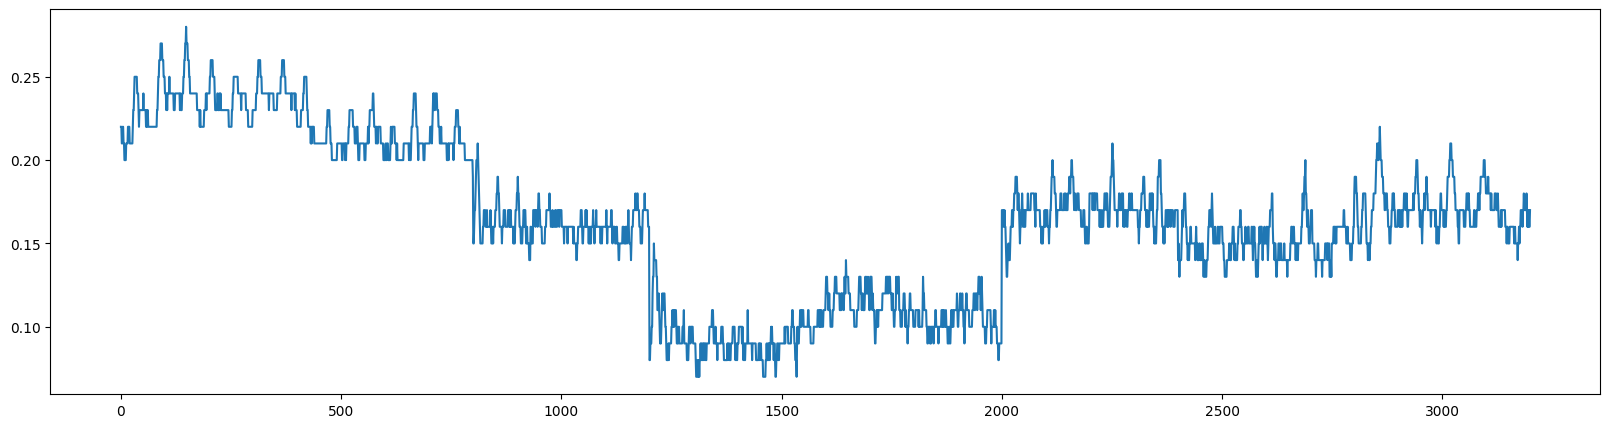

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(V_bias, label = "moving avg P")

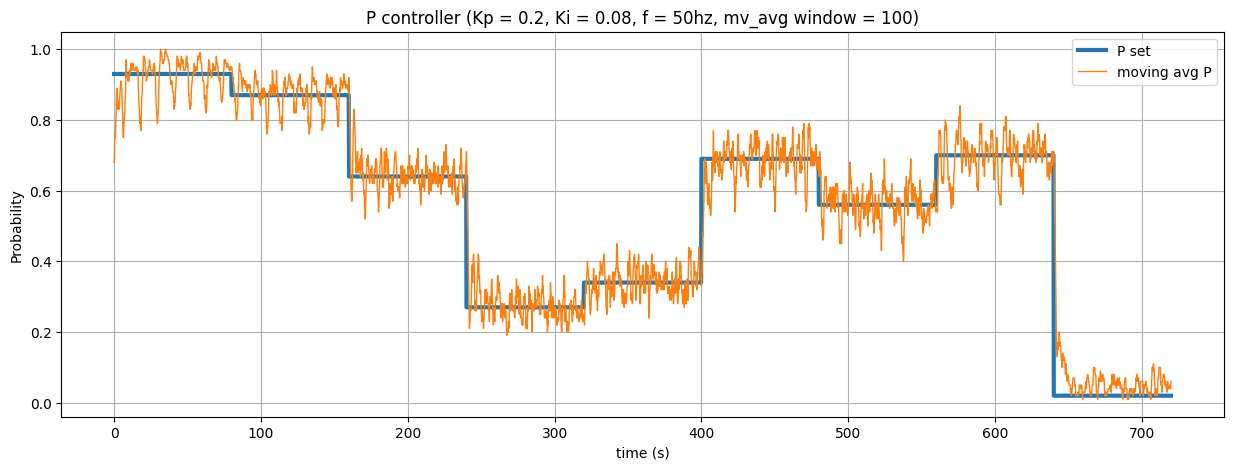

In [25]:
plt.figure(figsize=(15, 5))
# plt.plot(2,1,1)
plt.plot(t, P_set, label = "P set", linewidth = 3)
plt.plot(t, P_meas, label = "moving avg P", linewidth = 1)
plt.xlabel("time (s)")
plt.ylabel("Probability")
plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
plt.legend()
plt.grid()
# plt.subplot(2,1,2)
# plt.plot(V_bias, label = "moving avg P")

In [ ]:
# np.savez("meas1_10.5.24.npz", P_meas, P_set, V_bias)

In [27]:
data = np.load("meas1_10.5.24.npz")

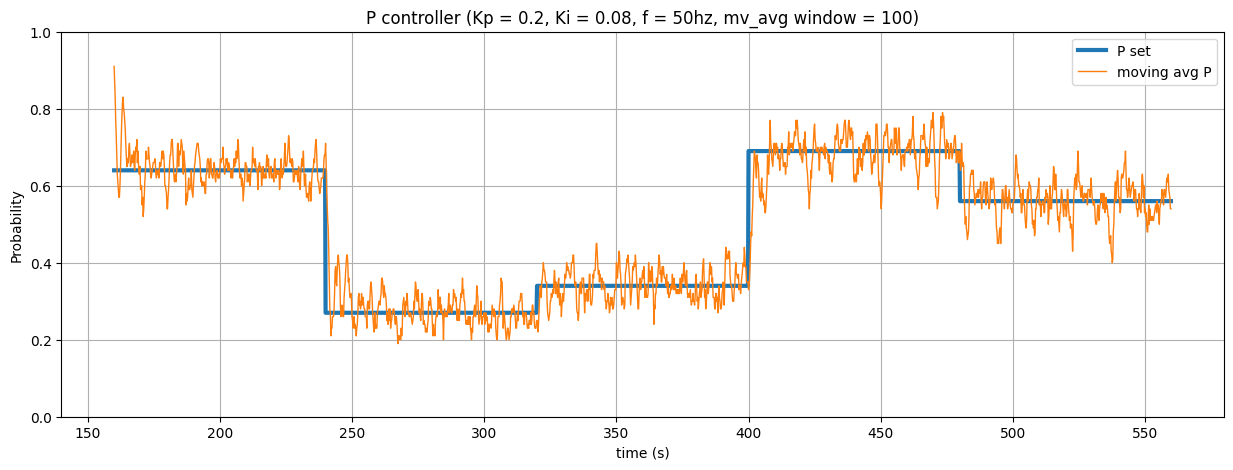

In [40]:
P_meas, P_set, V_bias = data['arr_0'], data['arr_1'], data['arr_2']
plt.figure(figsize=(15, 5))
# plt.plot(2,1,1)
to = 400*2
fro = 400*7
plt.plot(t[to:fro], P_set[to:fro], label = "P set", linewidth = 3)
plt.plot(t[to:fro], P_meas[to:fro], label = "moving avg P", linewidth = 1)
plt.xlabel("time (s)")
plt.ylabel("Probability")
plt.title("P controller (Kp = 0.2, Ki = 0.08, f = 50hz, mv_avg window = 100)")
plt.legend()
plt.ylim([0,1])
plt.grid()
plt.savefig("Pset_meas.pdf")

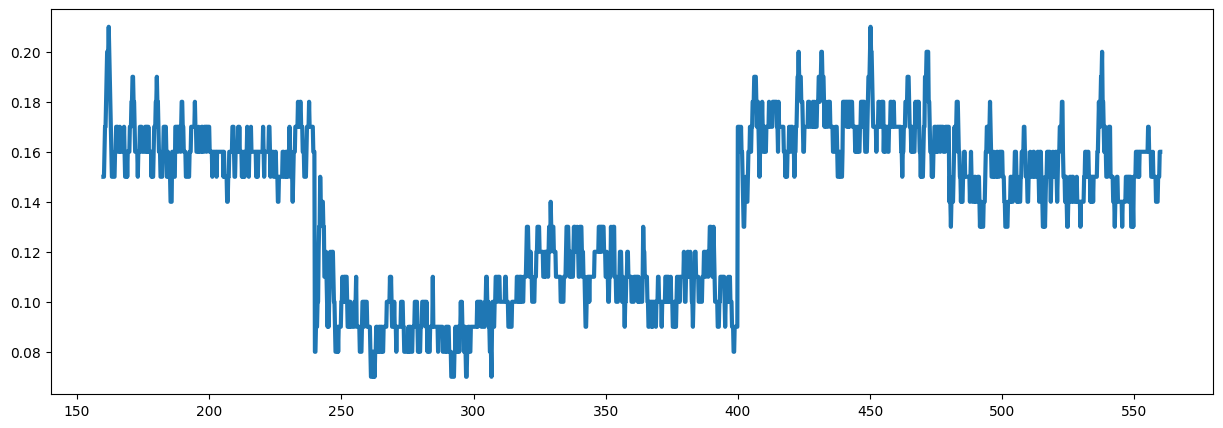

In [42]:
plt.figure(figsize=(15, 5))
plt.plot(t[to:fro], V_bias[to:fro], label = "P set", linewidth = 3)